# Assignment 2: Privacy-Preserving Data Sharing
### Security and Privacy Project - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995

## Anonymization with Differential Privacy

### Import dataset

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

infri = pd.read_csv('data/infringement_dataset_v2.csv')

infri.fillna(value = 0, inplace = True) 

display(infri)

loan_id  infringed    contract_type gender has_own_car has_own_realty  \
0        100002          1       Cash loans      M           N              Y   
1        100003          0       Cash loans      F           N              N   
2        100004          0  Revolving loans      M           Y              Y   
3        100006          0       Cash loans      F           N              Y   
4        100007          0       Cash loans      M           N              Y   
...         ...        ...              ...    ...         ...            ...   
307506   456251          0       Cash loans      M           N              N   
307507   456252          0       Cash loans      F           N              Y   
307508   456253          0       Cash loans      F           N              Y   
307509   456254          1       Cash loans      F           N              Y   
307510   456255          0       Cash loans      F           N              N   

        num_children  annual_income  credit_amount  credit_annuity  ...  \
0                  0       202500.0       406597.5         24700.5  ...   
1                  0       270000.0      1293502.5         35698.5  ...   
2                  0        67500.0       135000.0          6750.0  ...   
3                  0       135000.0       312682.5         29686.5  ...   
4                  0       121500.0       513000.0         21865.5  ...   
...              ...            ...            ...             ...  ...   
307506             0       157500.0       254700.0         27558.0  ...   
307507             0        72000.0       269550.0         12001.5  ...   
307508             0       153000.0       677664.0         29979.0  ...   
307509             0       171000.0       370107.0         20205.0  ...   
307510             0       157500.0       675000.0         49117.5  ...   

        first_name  last_name past_avg_amount_annuity  \
0           Robert    Watkins              9251.77500   
1             Jane    Navarro             56553.99000   
2            David  Seagraves              5357.25000   
3          Deborah      Tandy             23651.17500   
4            David     Walker             12278.80500   
...            ...        ...                     ...   
307506    Lawrence    Mcwayne              6605.91000   
307507     Belinda   Loveland             10074.46500   
307508      Aileen  Rasmussen              4770.40500   
307509        Mary    Marbury             10681.13250   
307510      Sophia     Murphy             20775.39188   

       past_avg_amt_application past_avg_amt_credit  past_loans_approved  \
0                    179055.000           179055.00                  1.0   
1                    435436.500           484191.00                  3.0   
2                     24282.000            20106.00                  1.0   
3                    272203.260           291695.50                  5.0   
4                    150530.250           166638.75                  6.0   
...                         ...                 ...                  ...   
307506                40455.000            40455.00                  1.0   
307507                57595.500            56821.50                  1.0   
307508                24162.750            20625.75                  2.0   
307509               121317.750           134439.75                  2.0   
307510               362770.875           424431.00                  6.0   

        past_loans_refused  past_loans_canceled  past_loans_unused  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      3.0                  1.0                0.0   
4                      0.0                  0.0                0.0   
...                    ...                  ...                ...   
307506                 0.0                  0.

### Data

In [100]:
from matplotlib import pyplot as plt
columns = ['age', 'past_avg_amount_annuity', 'past_avg_amt_application', 'past_avg_amt_credit', 'past_loans_total']
colunas = infri[columns]

display(colunas)

age  past_avg_amount_annuity  past_avg_amt_application  \
0        25               9251.77500                179055.000   
1        45              56553.99000                435436.500   
2        52               5357.25000                 24282.000   
3        52              23651.17500                272203.260   
4        54              12278.80500                150530.250   
...     ...                      ...                       ...   
307506   25               6605.91000                 40455.000   
307507   56              10074.46500                 57595.500   
307508   41               4770.40500                 24162.750   
307509   32              10681.13250                121317.750   
307510   46              20775.39188                362770.875   

        past_avg_amt_credit  past_loans_total  
0                 179055.00               1.0  
1                 484191.00               3.0  
2                  20106.00               1.0  
3                 291695.50               9.0  
4                 166638.75               6.0  
...                     ...               ...  
307506             40455.00               1.0  
307507             56821.50               1.0  
307508             20625.75               2.0  
307509            134439.75               2.0  
307510            424431.00               8.0  

[307511 rows x 5 columns]

### 2.2. Sensitivity

In [101]:
def sensitivity_mean(data):
    l = []
    data = data.to_numpy()

    mean_past = np.average(data)
    print("Total mean:", mean_past)

    for i in range(len(data)):
        aux = np.average(np.delete(data, i))
        l.append(abs(mean_past - aux))
    
    return max(l)

### Past_Events

In [102]:
df_sensitivity = pd.DataFrame(columns=columns[1:], index = ["Original Sensitivity"])

s_annuity = sensitivity_mean(colunas['past_avg_amount_annuity'])
s_application = sensitivity_mean(colunas['past_avg_amt_application'])
s_credit = sensitivity_mean(colunas['past_avg_amt_credit'])
s_loans = sensitivity_mean(colunas['past_loans_total'])

df_sensitivity.loc["Original Sensitivity"] = [s_annuity, s_application, s_credit, s_loans]

display(df_sensitivity)

Total mean: 13734.779634713375
Total mean: 145765.11039217902
Total mean: 160970.077379683
Total mean: 4.597237172003603


past_avg_amount_annuity past_avg_amt_application  \
Original Sensitivity                0.932297                12.696286   

                     past_avg_amt_credit past_loans_total  
Original Sensitivity           12.646841         0.000222

### 2.3. Differential Privacy

In [103]:
def add_laplace_noise(data, column, sensitivity, epsilon):
  data_aux = data.copy()
  data_aux = data_aux.to_numpy()

  for i in range(len(data_aux)):
    laplace = np.random.laplace(loc=0, scale=sensitivity/epsilon)
    data_aux[i] = data_aux[i] + laplace

  df = pd.DataFrame(data_aux, columns = [column])
  return df[column]

### Adding noise

In [104]:
noise_annuity_001 = add_laplace_noise(colunas['past_avg_amount_annuity'], 'past_avg_amount_annuity', s_annuity, 0.01)
s_annuity_001 = sensitivity_mean(noise_annuity_001)

noise_application_001 = add_laplace_noise(colunas['past_avg_amt_application'], 'past_avg_amt_application', s_application, 0.01)
s_application_001 = sensitivity_mean(noise_application_001)

noise_credit_001 = add_laplace_noise(colunas['past_avg_amt_credit'], 'past_avg_amt_credit', s_credit, 0.01)
s_credit_001 = sensitivity_mean(noise_credit_001)

noise_loans_001 = add_laplace_noise(colunas['past_loans_total'], 'past_loans_total', s_loans, 0.01)
s_loans_001 = sensitivity_mean(noise_loans_001)

df_sensitivity.loc["Epsilon = 0.01"] = [s_annuity_001, s_application_001, s_credit_001, s_loans_001]
display(df_sensitivity)



Total mean: 13734.75757248655
Total mean: 145762.201632933
Total mean: 160970.9331337854
Total mean: 4.597254832413279


past_avg_amount_annuity past_avg_amt_application  \
Original Sensitivity                0.932297                12.696286   
Epsilon = 0.01                      0.931556                12.703533   

                     past_avg_amt_credit past_loans_total  
Original Sensitivity           12.646841         0.000222  
Epsilon = 0.01                 12.650964         0.000222

In [105]:
noise_annuity_02 = add_laplace_noise(colunas['past_avg_amount_annuity'], 'past_avg_amount_annuity', s_annuity, 0.2)
s_annuity_02 = sensitivity_mean(noise_annuity_02)

noise_application_02 = add_laplace_noise(colunas['past_avg_amt_application'], 'past_avg_amt_application', s_application, 0.2)
s_application_02 = sensitivity_mean(noise_application_02)

noise_credit_02 = add_laplace_noise(colunas['past_avg_amt_credit'], 'past_avg_amt_credit', s_credit, 0.2)
s_credit_02 = sensitivity_mean(noise_credit_02)

noise_loans_02 = add_laplace_noise(colunas['past_loans_total'], 'past_loans_total', s_loans, 0.2)
s_loans_02 = sensitivity_mean(noise_loans_02)

df_sensitivity.loc["Epsilon = 0.2"] = [s_annuity_02, s_application_02, s_credit_02, s_loans_02]
display(df_sensitivity)

Total mean: 13734.774077477618
Total mean: 145765.15174121113
Total mean: 160970.3277097372
Total mean: 4.5972339339686386


past_avg_amount_annuity past_avg_amt_application  \
Original Sensitivity                0.932297                12.696286   
Epsilon = 0.01                      0.931556                12.703533   
Epsilon = 0.2                       0.932257                12.695973   

                     past_avg_amt_credit past_loans_total  
Original Sensitivity           12.646841         0.000222  
Epsilon = 0.01                 12.650964         0.000222  
Epsilon = 0.2                  12.646719         0.000222

In [106]:
noise_annuity_l2 = add_laplace_noise(colunas['past_avg_amount_annuity'], 'past_avg_amount_annuity', s_annuity, np.log(2))
s_annuity_l2 = sensitivity_mean(noise_annuity_l2)

noise_application_l2 = add_laplace_noise(colunas['past_avg_amt_application'], 'past_avg_amt_application', s_application, np.log(2))
s_application_l2 = sensitivity_mean(noise_application_l2)

noise_credit_l2 = add_laplace_noise(colunas['past_avg_amt_credit'], 'past_avg_amt_credit', s_credit, np.log(2))
s_credit_l2 = sensitivity_mean(noise_credit_l2)

noise_loans_l2 = add_laplace_noise(colunas['past_loans_total'], 'past_loans_total', s_loans, np.log(2))
s_loans_l2 = sensitivity_mean(noise_loans_l2)

df_sensitivity.loc["Epsilon = ln(2)"] = [s_annuity_l2, s_application_l2, s_credit_l2, s_loans_l2]
display(df_sensitivity)

Total mean: 13734.777772761228
Total mean: 145765.06198471523
Total mean: 160970.11373088733
Total mean: 4.597237764841929


past_avg_amount_annuity past_avg_amt_application  \
Original Sensitivity                0.932297                12.696286   
Epsilon = 0.01                      0.931556                12.703533   
Epsilon = 0.2                       0.932257                12.695973   
Epsilon = ln(2)                     0.932294                12.696307   

                     past_avg_amt_credit past_loans_total  
Original Sensitivity           12.646841         0.000222  
Epsilon = 0.01                 12.650964         0.000222  
Epsilon = 0.2                  12.646719         0.000222  
Epsilon = ln(2)                12.646955         0.000222

In [107]:
noise_annuity_l3 = add_laplace_noise(colunas['past_avg_amount_annuity'], 'past_avg_amount_annuity', s_annuity, np.log(3))
s_annuity_l3 = sensitivity_mean(noise_annuity_l3)

noise_application_l3 = add_laplace_noise(colunas['past_avg_amt_application'], 'past_avg_amt_application', s_application, np.log(3))
s_application_l3 = sensitivity_mean(noise_application_l3)

noise_credit_l3 = add_laplace_noise(colunas['past_avg_amt_credit'], 'past_avg_amt_credit', s_credit, np.log(3))
s_credit_l3 = sensitivity_mean(noise_credit_l3)

noise_loans_l3 = add_laplace_noise(colunas['past_loans_total'], 'past_loans_total', s_loans, np.log(3))
s_loans_l3 = sensitivity_mean(noise_loans_l3)

df_sensitivity.loc["Epsilon = ln(3)"] = [s_annuity_l3, s_application_l3, s_credit_l3, s_loans_l3]
display(df_sensitivity)

Total mean: 13734.780314867345
Total mean: 145765.09573613745
Total mean: 160970.06818200878
Total mean: 4.597237484508606


past_avg_amount_annuity past_avg_amt_application  \
Original Sensitivity                0.932297                12.696286   
Epsilon = 0.01                      0.931556                12.703533   
Epsilon = 0.2                       0.932257                12.695973   
Epsilon = ln(2)                     0.932294                12.696307   
Epsilon = ln(3)                       0.9323                  12.6962   

                     past_avg_amt_credit past_loans_total  
Original Sensitivity           12.646841         0.000222  
Epsilon = 0.01                 12.650964         0.000222  
Epsilon = 0.2                  12.646719         0.000222  
Epsilon = ln(2)                12.646955         0.000222  
Epsilon = ln(3)                12.646747         0.000222

### Analysis of sensitivity

Comparison of sensitivity in different epsilons


<Figure size 432x288 with 0 Axes>

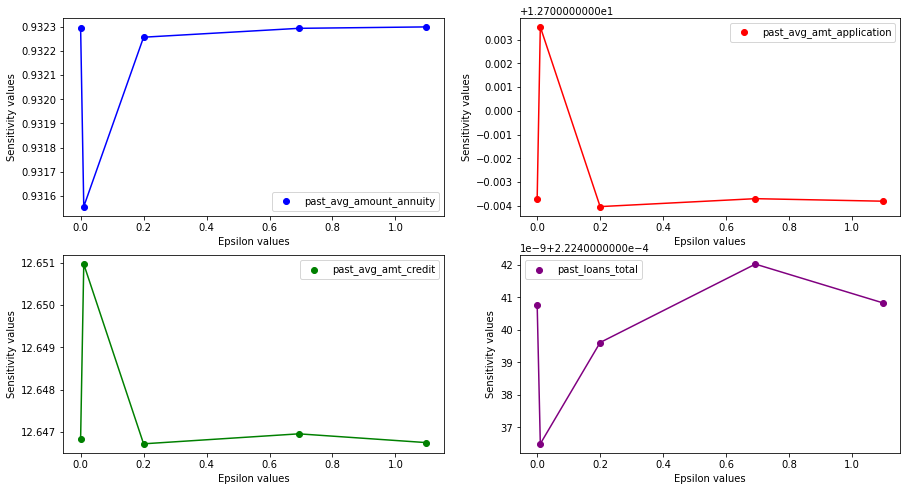

In [108]:
s_annuity_a = [s_annuity, s_annuity_001, s_annuity_02, s_annuity_l2, s_annuity_l3]
s_application_a = [s_application, s_application_001, s_application_02, s_application_l2, s_application_l3]
s_credit_a = [s_credit, s_credit_001, s_credit_02, s_credit_l2, s_credit_l3]
s_loans_a = [s_loans, s_loans_001, s_loans_02, s_loans_l2, s_loans_l3]

epsilon_values = [0, 0.01, 0.2, np.log(2), np.log(3)]

plt.figure()
plt.subplots(2, 2, figsize=(15, 8))

print("Comparison of sensitivity in different epsilons")

def plot(num, column, x, y, color):    
    plt.subplot(2, 2, num)
    plt.xlabel("Epsilon values")
    plt.ylabel("Sensitivity values")
    plt.plot(x, y, color = color)
    plt.scatter(x, y, color = color, label= column)
    plt.legend()


plot(1, 'past_avg_amount_annuity', epsilon_values, s_annuity_a, 'blue')
plot(2,'past_avg_amt_application', epsilon_values, s_application_a, 'red')
plot(3, 'past_avg_amt_credit', epsilon_values, s_credit_a, 'green')
plot(4, 'past_loans_total', epsilon_values, s_loans_a, 'purple')


### Past_events group by age

In [109]:
columns = ['age', 'past_avg_amount_annuity', 'past_avg_amt_application', 'past_avg_amt_credit', 'past_loans_total']

noise_df_001 = pd.DataFrame(columns=columns)
noise_df_001["age"] = infri["age"]
noise_df_001['past_avg_amount_annuity'] = noise_annuity_001
noise_df_001['past_avg_amt_application'] = noise_application_001
noise_df_001['past_avg_amt_credit'] = noise_credit_001
noise_df_001['past_loans_total'] = noise_loans_001

noise_df_02 = pd.DataFrame(columns=columns)
noise_df_02["age"] = infri["age"]
noise_df_02['past_avg_amount_annuity'] = noise_annuity_02
noise_df_02['past_avg_amt_application'] = noise_application_02
noise_df_02['past_avg_amt_credit'] = noise_credit_02
noise_df_02['past_loans_total'] = noise_loans_02

noise_df_l2 = pd.DataFrame(columns=columns)
noise_df_l2["age"] = infri["age"]
noise_df_l2['past_avg_amount_annuity'] = noise_annuity_l2
noise_df_l2['past_avg_amt_application'] = noise_application_l2
noise_df_l2['past_avg_amt_credit'] = noise_credit_l2
noise_df_l2['past_loans_total'] = noise_loans_l2

noise_df_l3 = pd.DataFrame(columns=columns)
noise_df_l3["age"] = infri["age"]
noise_df_l3['past_avg_amount_annuity'] = noise_annuity_l3
noise_df_l3['past_avg_amt_application'] = noise_application_l3
noise_df_l3['past_avg_amt_credit'] = noise_credit_l3
noise_df_l3['past_loans_total'] = noise_loans_l3


In [110]:
groupby_age_original = colunas.groupby("age").mean()
groupby_age_001 = noise_df_001.groupby("age").mean()
groupby_age_02 = noise_df_02.groupby("age").mean()
groupby_age_l2 = noise_df_l2.groupby("age").mean()
groupby_age_l3 = noise_df_l3.groupby("age").mean()


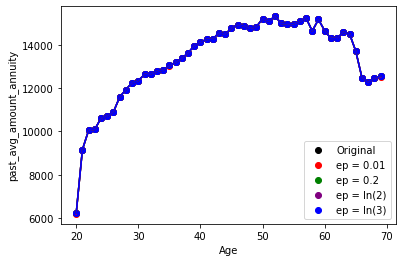

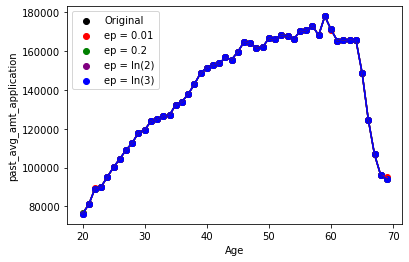

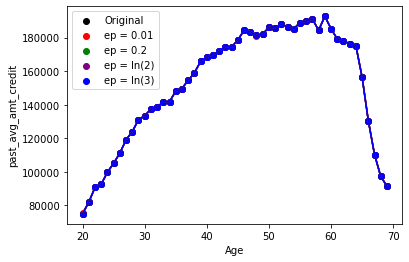

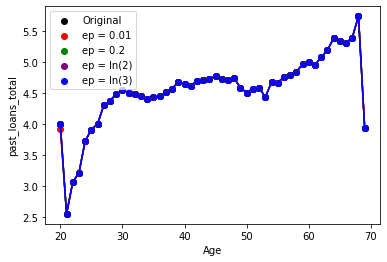

In [111]:
def plot_age(column, x, y):   
    plt.figure()
    plt.xlabel("Age")
    plt.ylabel(column)
    plt.plot(x, y[0], color = 'black')
    plt.scatter(x, y[0], color = 'black', label= "Original")
    plt.plot(x, y[1], color = 'red')
    plt.scatter(x, y[1], color = 'red', label= "ep = 0.01")
    plt.plot(x, y[2], color = 'green')
    plt.scatter(x, y[2], color = 'green', label= "ep = 0.2")
    plt.plot(x, y[3], color = 'purple')
    plt.scatter(x, y[3], color = 'purple', label= "ep = ln(2)")
    plt.plot(x, y[4], color = 'blue')
    plt.scatter(x, y[4], color = 'blue', label= "ep = ln(3)")
    plt.legend()


plot_age('past_avg_amount_annuity', np.arange(20,70), [groupby_age_original['past_avg_amount_annuity'], groupby_age_001['past_avg_amount_annuity'], groupby_age_02['past_avg_amount_annuity'], groupby_age_l2['past_avg_amount_annuity'], groupby_age_l3['past_avg_amount_annuity']])
plot_age('past_avg_amt_application', np.arange(20,70), [groupby_age_original['past_avg_amt_application'], groupby_age_001['past_avg_amt_application'], groupby_age_02['past_avg_amt_application'], groupby_age_l2['past_avg_amt_application'], groupby_age_l3['past_avg_amt_application']])
plot_age('past_avg_amt_credit', np.arange(20,70), [groupby_age_original['past_avg_amt_credit'], groupby_age_001['past_avg_amt_credit'], groupby_age_02['past_avg_amt_credit'], groupby_age_l2['past_avg_amt_credit'], groupby_age_l3['past_avg_amt_credit']])
plot_age('past_loans_total', np.arange(20,70), [groupby_age_original['past_loans_total'], groupby_age_001['past_loans_total'], groupby_age_02['past_loans_total'], groupby_age_l2['past_loans_total'], groupby_age_l3['past_loans_total']])


### Percentage of individuals with infringed loans by age

In [112]:
infri_age = infri[['infringed', 'age']]
display(infri_age)

infringed  age
0               1   25
1               0   45
2               0   52
3               0   52
4               0   54
...           ...  ...
307506          0   25
307507          0   56
307508          0   41
307509          1   32
307510          0   46

[307511 rows x 2 columns]

In [113]:
s_age = sensitivity_mean(infri_age["age"])

res_age = pd.DataFrame(columns=["Age"], index = ["Original Sensitivity"])
res_age.loc["Original Sensitivity"] = s_age
display(res_age)


Total mean: 43.43596814422899


Age
Original Sensitivity  0.000083

### Sensitivity

In [114]:
dp_age_001 = add_laplace_noise(infri_age["age"], "age", s_age, 0.01)
s_age_001 = sensitivity_mean(dp_age_001)
res_age.loc["Epsilon = 0.01"] = s_age_001

dp_age_02 = add_laplace_noise(infri_age["age"], "age", s_age, 0.2)
s_age_02 = sensitivity_mean(dp_age_02)
res_age.loc["Epsilon = 0.2"] = s_age_02

dp_age_l2 = add_laplace_noise(infri_age["age"], "age", s_age, np.log(2))
s_age_l2 = sensitivity_mean(dp_age_l2)
res_age.loc["Epsilon = ln(2)"] = s_age_l2

dp_age_l3 = add_laplace_noise(infri_age["age"], "age", s_age, np.log(3))
s_age_l3 = sensitivity_mean(dp_age_l3)
res_age.loc["Epsilon = ln(3)"] = s_age_l3

display(res_age)

Total mean: 42.936454305699634
Total mean: 42.935625067070774
Total mean: 42.93572587647271
Total mean: 42.93606732767283


Age
Original Sensitivity  0.000083
Epsilon = 0.01        0.000085
Epsilon = 0.2         0.000085
Epsilon = ln(2)       0.000085
Epsilon = ln(3)       0.000085

### Analysis of sensitivity

Comparison of sensitivity in different epsilons


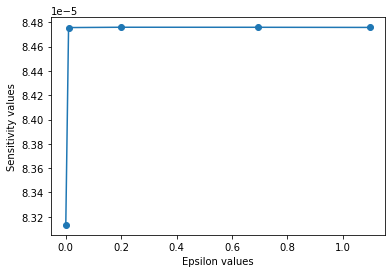

In [117]:

epsilon_values = [0, 0.01, 0.2, np.log(2), np.log(3)]

plt.figure()

print("Comparison of sensitivity in different epsilons")

y = [s_age, s_age_001, s_age_02, s_age_l2, s_age_l3]
plt.xlabel("Epsilon values")
plt.ylabel("Sensitivity values")
plt.plot(epsilon_values, y)
plt.scatter(epsilon_values, y)

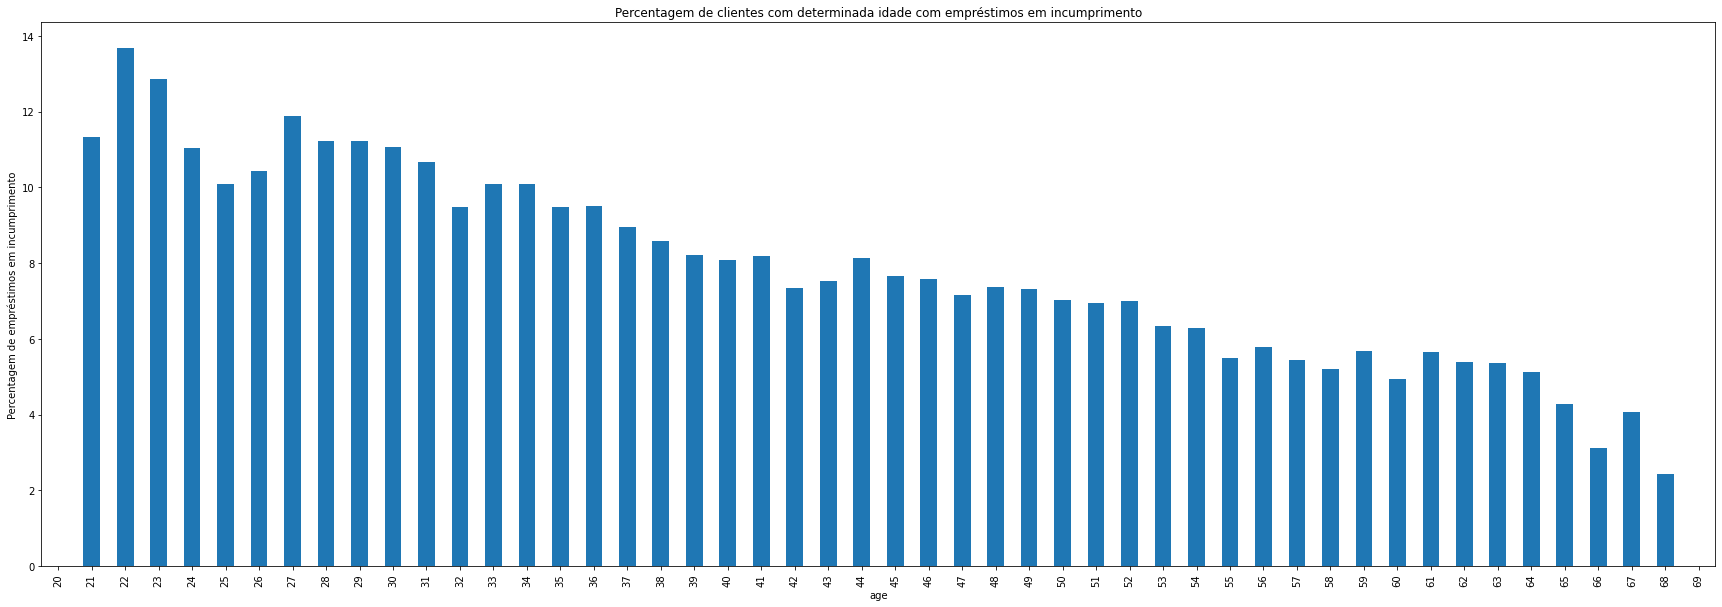

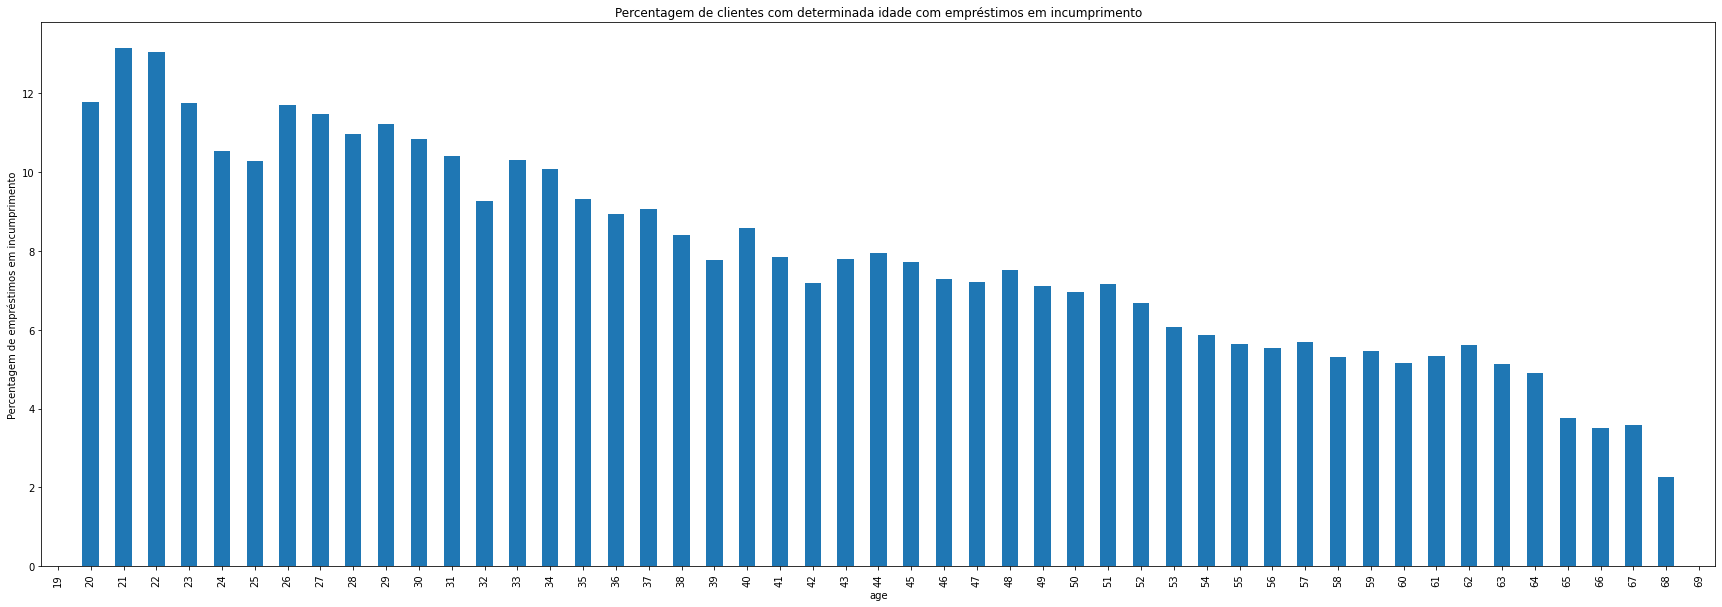

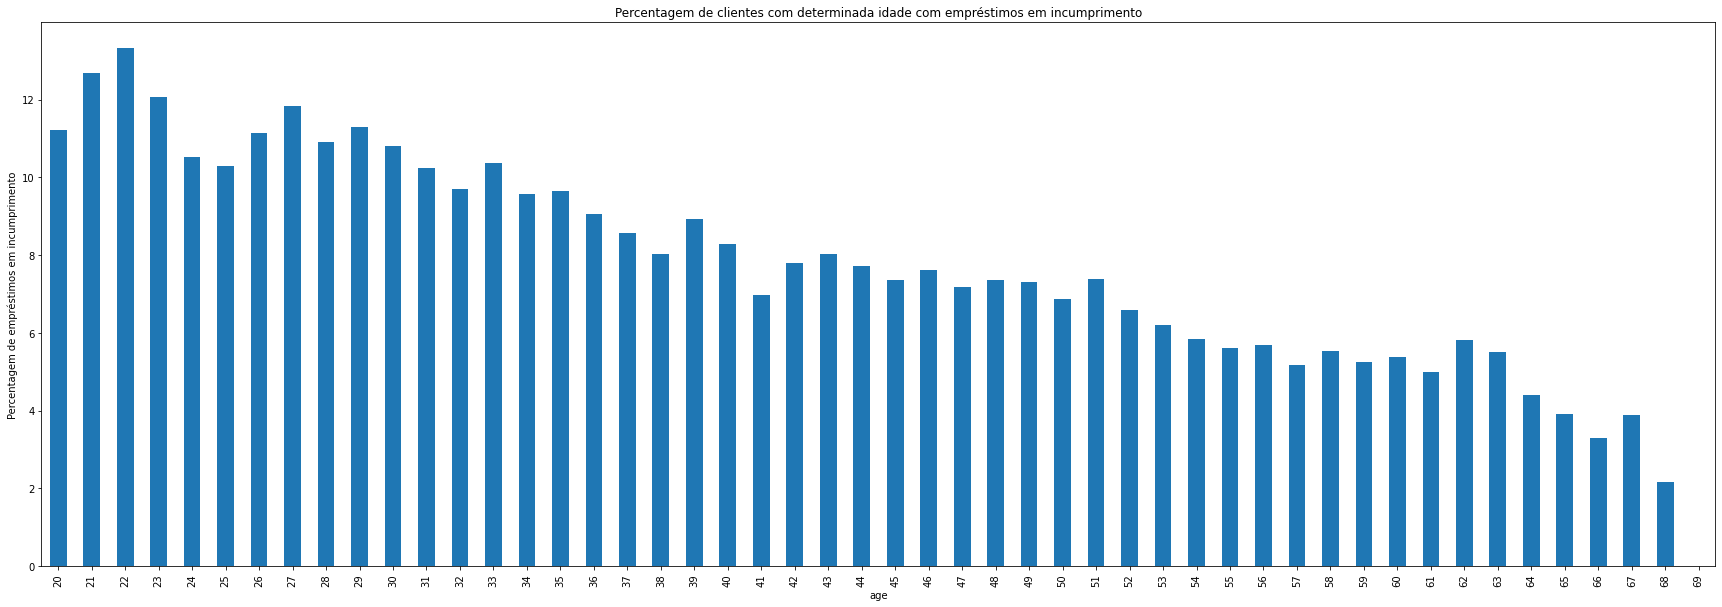

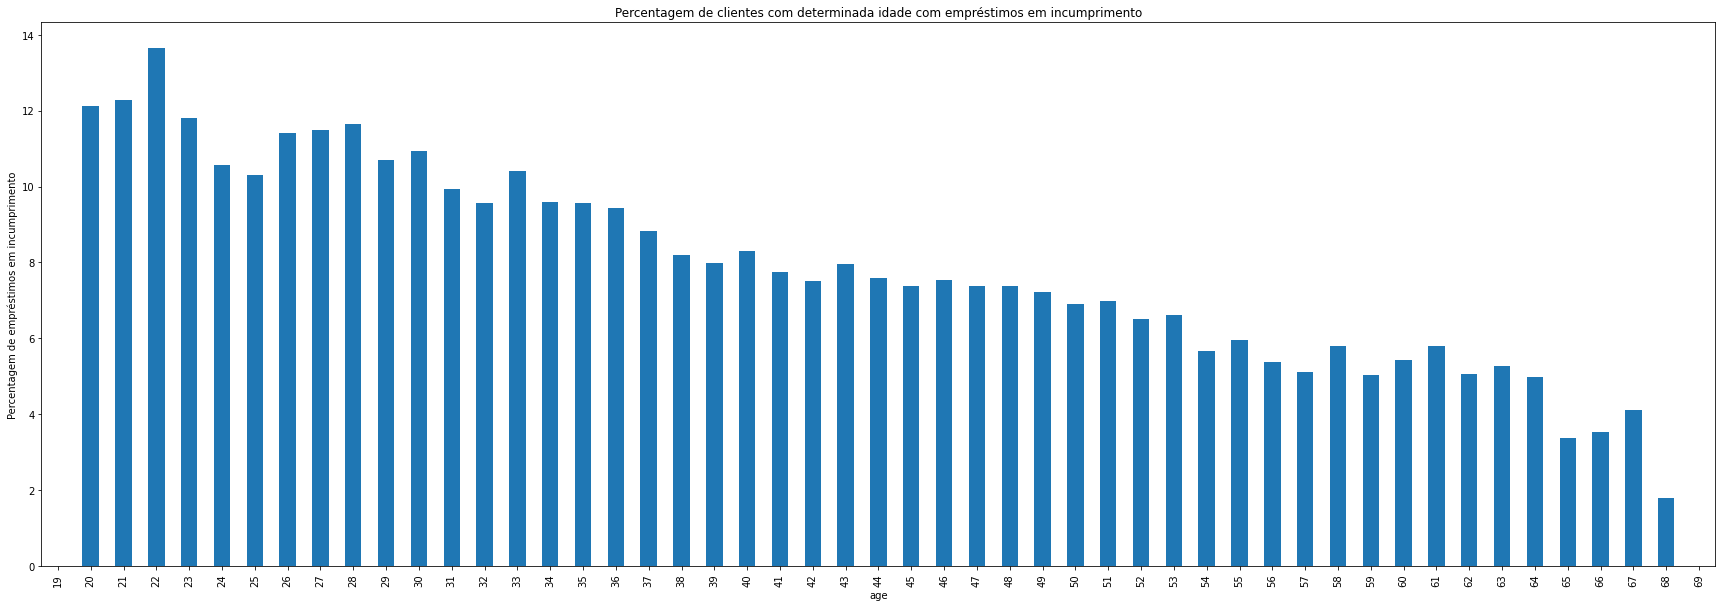

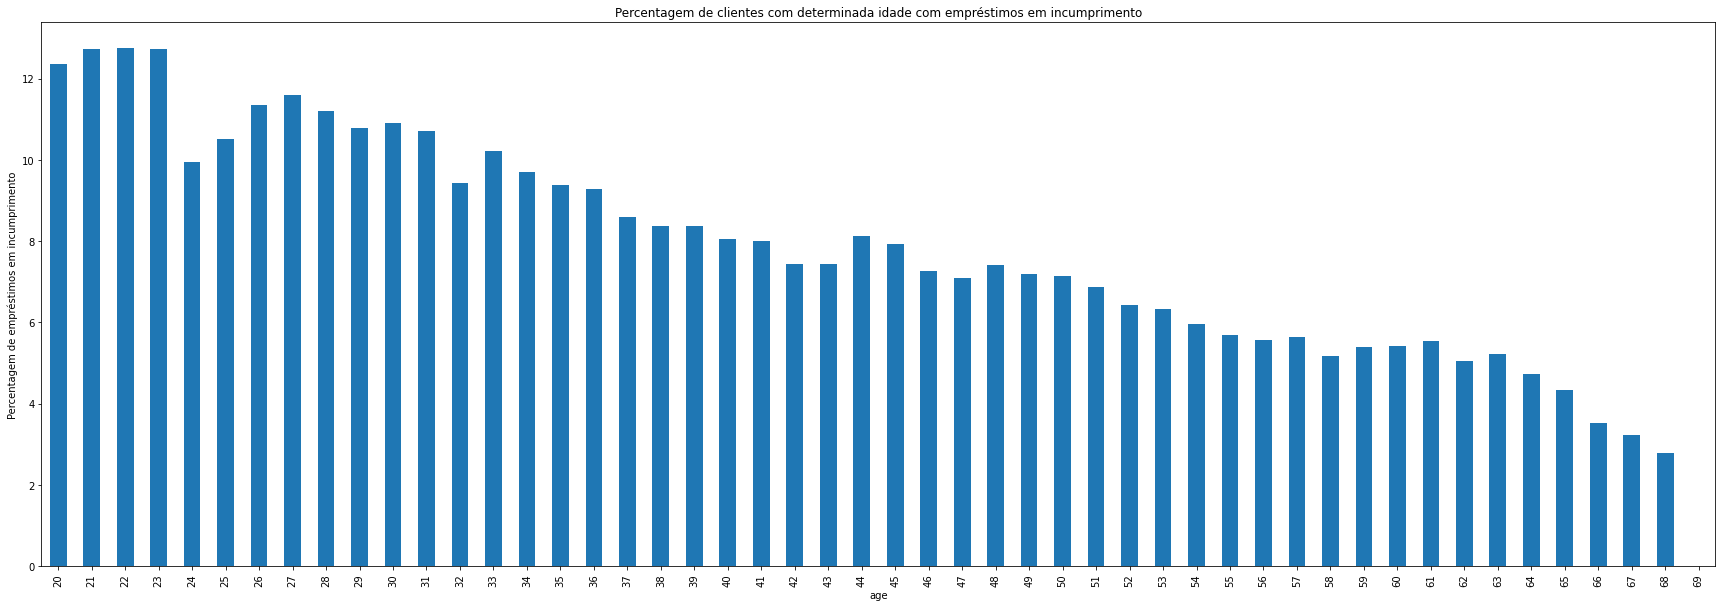

In [116]:
def bar(data):
    plt.figure()
    count_inf = data[data['infringed']==1.0].groupby(['age']).size()

    age = data.groupby(['age']).size()


    plt.title("Percentagem de clientes com determinada idade com empréstimos em incumprimento")
    plt.xlabel("Idade dos clientes")
    plt.ylabel("Percentagem de empréstimos em incumprimento")

    ((count_inf/age)*100).plot(figsize=(30,10), kind='bar')

bar(infri_age)

data = pd.DataFrame(columns=['infringed', 'age'])
data["infringed"] = infri_age["infringed"]
data['age'] = dp_age_001

bar(data)

data = pd.DataFrame(columns=['infringed', 'age'])
data["infringed"] = infri_age["infringed"]
data['age'] = dp_age_02

bar(data)

data = pd.DataFrame(columns=['infringed', 'age'])
data["infringed"] = infri_age["infringed"]
data['age'] = dp_age_l2

bar(data)

data = pd.DataFrame(columns=['infringed', 'age'])
data["infringed"] = infri_age["infringed"]
data['age'] = dp_age_l3

bar(data)